In [9]:
!pip install accelerate>=0.20.1 -U

Runtime --> restart session

執行以下會遇到問題。請參考[這裏](https://discuss.huggingface.co/t/trainingargument-does-not-work-on-colab/43372/5)

# 章節簡介

在第三章，您瞭解瞭如何微調文本分類的模型。在本章中，我們將處理以下常見NLP任務：

*   標記(token)分類
*   遮罩語言建模（如BERT）
*   提取文本摘要
*   翻譯
*   因果語言建模預訓練（如GPT-2）
*   問答

為此，您需要利用第三章中學到的Trainer API 和🤗Accelerate 庫、第五章中的 🤗 Datasets 庫以及第六章中的 🤗 Tokenizers 庫的所有知識。我們還會將結果上傳到模型中心，就像我們在第四章中所做的那樣，所以這確實是將之前所有內容彙集在一起的章節！

每個部分都可以獨立閱讀，並將向您展示如何使用API或按照您自己的訓練循環訓練模型，使用🤗 Accelerate 加速。你可以隨意跳過其中一部分，把注意力集中在你最感興趣的那一部分：API可以優化或訓練您的模型而無需擔心幕後發生了什麼，而訓練循環使用可以讓您更輕鬆地自定義所需的任何結構。

## Token 分類

我們將探索的第一個應用是Token分類。這個通用任務包括任何可以表述為“為句子中的詞或字分配標籤”的問題，例如：

*   實體命名識別 (NER): 找出句子中的實體（如人物、地點或組織）。這可以通過為每個實體或“無實體”指定一個類別的標籤。
*   詞性標註 (POS): 將句子中的每個單詞標記為對應於特定的詞性（如名詞、動詞、形容詞等）。
*   分塊（chunking）: 找到屬於同一實體的Token。這個任務(可結合POS或NER)可以任何將一塊Token作為制定一個標籤(通常是B -),另一個標籤(通常I -)表示Token是否是同一塊,和第三個標籤(通常是O)表示Token不屬於任何塊。也就是標出句子中的短語塊，例如名詞短語（NP），動詞短語（VP）等。

當然，還有很多其他類型的token分類問題；這些只是幾個有代表性的例子。在本節中，我們將在 NER 任務上微調模型 (BERT)，然後該模型將能夠計算如下預測：

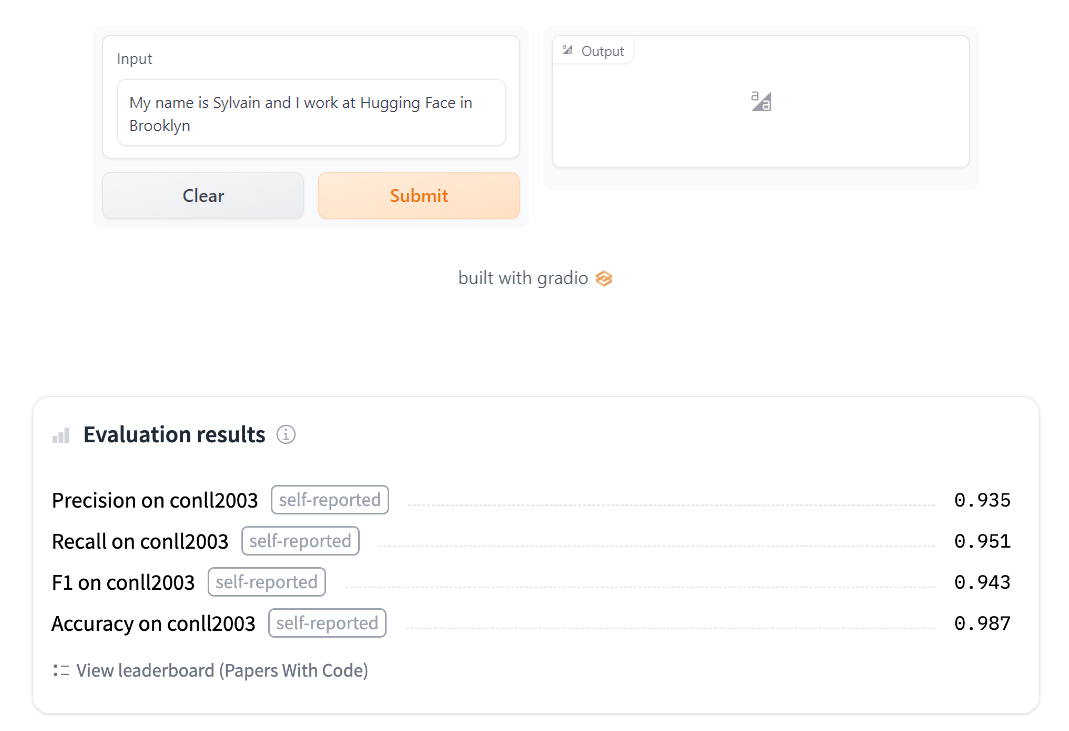

您可以在[這裡](https://huggingface.co/huggingface-course/bert-finetuned-ner?text=My+name+is+Sylvain+and+I+work+at+Hugging+Face+in+Brooklyn).找到我們將訓練並上傳到 Hub的模型，可以嘗試輸入一些句子看看模型的預測結果。

## 準備數據
首先，我們需要一個適合標記分類的數據集。在本節中，我們將使用CoNLL-2003 數據集, 其中包含來自路透社的新聞報道。

### CoNLL-2003 數據集
要加載 CoNLL-2003 數據集，我們使用 來自 🤗 Datasets 庫的load_dataset() 方法：

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

這將下載並緩存數據集，就像和我們在第三章 加載GLUE MRPC 數據集一樣。檢查這個對象可以讓我們看到存在哪些列，以及訓練集、驗證集和測試集之間是如何分割的:

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

特別是，我們可以看到數據集包含我們之前提到的三個任務的標籤：NER、POS 和chunking。與其他數據集的一個很大區別是輸入文本不是作為句子或文檔呈現的，而是單詞列表（最後一列稱為 tokens ，但它包含的是這些詞是預先標記化的輸入，仍然需要通過標記器進行子詞標記）。

我們來看看訓練集的第一個元素：

In [ ]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

由於我們要執行命名實體識別，我們將查看 NER 標籤：

In [ ]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

這一列是類標籤的序列。元素的類型在ner_feature的feature屬性中，我們可以通過查看該特性的names屬性來訪問名稱列表:

In [ ]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

因此，這一列包含的元素是ClassLabels的序列。序列元素的類型在ner_feature的feature中，我們可以通過查看該feature的names屬性來訪問名稱列表:

In [ ]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

我們在第六章, 深入研究token-classification 管道時已經看到了這些標籤 ，但為了快速複習：

*   O 表示這個詞不對應任何實體。
*   B-PER/I-PER意味著這個詞對應於人名實體的開頭/內部。
*   B-ORG/I-ORG 的意思是這個詞對應於組織名稱實體的開頭/內部。
*   B-LOC/I-LOC 指的是是這個詞對應於地名實體的開頭/內部。
*   B-MISC/I-MISC 表示該詞對應於一個雜項實體的開頭/內部。

現在解碼我們之前看到的標籤：

In [ ]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


例如混合 B- 和 I- 標籤，這是相同的代碼在索引 4 的訓練集元素上的預測結果：

In [ ]:
words = raw_datasets["train"][4]["tokens"]
labels = raw_datasets["train"][4]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer . 
B-LOC   O  O              O  O   B-ORG    I-ORG O  O          O         B-PER  I-PER     O    O  O         O         O      O   O         O    O         O     O    B-LOC   O     O   O          O      O   O       O 


## 處理數據

像往常一樣，我們的文本需要轉換為Token ID，然後模型才能理解它們。正如我們在第六章所學的那樣。不過在標記任務中，一個很大的區別是我們有pre-tokenized的輸入。幸運的是，tokenizer API可以很容易地處理這個問題;我們只需要用一個特殊的tokenizer。

首先，讓我們創建tokenizer對象。如前所述，我們將使用 BERT 預訓練模型，因此我們將從下載並緩存關聯的分詞器開始：

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

你可以更換把 model_checkpoint 更換為 Hub,上您喜歡的任何其他型號，或使用您本地保存的預訓練模型和分詞器。唯一的限制是分詞器需要由 🤗 Tokenizers 庫支持，有一個“快速”版本可用。你可以在這張大表, 上看到所有帶有快速版本的架構，或者檢查 您可以通過查看它is_fast 屬性來檢測正在使用的tokenizer對象是否由 🤗 Tokenizers 支持：

In [ ]:
tokenizer.is_fast

True

要對預先標記的輸入進行標記，我們可以像往常一樣使用我們的tokenizer 只需添加 is_split_into_words=True:

In [ ]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

正如我們所見，分詞器添加了模型使用的特殊Token([CLS] 在開始和[SEP] 最後) 而大多數單詞未被修改。然而，單詞 lamb,被分為兩個子單詞 la and ##mb。這導致了輸入和標籤之間的不匹配:標籤列表只有9個元素，而我們的輸入現在有12個token 。計算特殊Token很容易(我們知道它們在開頭和結尾)，但我們還需要確保所有標籤與適當的單詞對齊。 幸運的是，由於我們使用的是快速分詞器，因此我們可以訪問🤗 Tokenizers超能力，這意味著我們可以輕鬆地將每個令牌映射到其相應的單詞（如Chapter 6):

In [ ]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

通過一點點工作，我們可以擴展我們的標籤列表以匹配token 。我們將應用的第一條規則是，特殊token 的標籤為 -100 。這是因為默認情況下 -100 是一個在我們將使用的損失函數（交叉熵）中被忽略的索引。然後，每個token 都會獲得與其所在單詞的token 相同的標籤，因為它們是同一實體的一部分。對於單詞內部但不在開頭的Token，我們將B- 替換為 I- (因為token 不以實體開頭):

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

讓我們在我們的第一句話上試一試：

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


正如我們所看到的，我們的函數為開頭和結尾的兩個特殊標記添加了 -100 ，併為分成兩個標記的單詞添加了一個新的0 。

為了預處理我們的整個數據集，我們需要標記所有輸入並在所有標籤上應用 align_labels_with_tokens() 。為了利用我們的快速分詞器的速度優勢，最好同時對大量文本進行分詞，因此我們將編寫一個處理示例列表的函數並使用帶 batched=True 有選項的 Dataset.map()方法 .與我們之前的示例唯一不同的是當分詞器的輸入是文本列表（或者像例子中的單詞列表）時 word_ids() 函數需要獲取我們想要單詞的索引的ID，所以我們也添加它：

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
t_input = tokenize_and_align_labels(raw_datasets["train"][2:4])
print(t_input)

{'input_ids': [[101, 26660, 13329, 12649, 15928, 1820, 118, 4775, 118, 1659, 102], [101, 1109, 1735, 2827, 1163, 1113, 9170, 1122, 19786, 1114, 1528, 5566, 1106, 11060, 1106, 188, 17315, 1418, 2495, 12913, 1235, 6479, 4959, 2480, 6340, 13991, 3653, 1169, 1129, 12086, 1106, 8892, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 5, 6, 6, 6, 0, 0, 0, 0, 0, -100], [-100, 0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]]}


In [ ]:
raw_datasets["train"].column_names

['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']

請注意，我們還沒有填充我們的輸入；我們稍後會在使用數據整理器創建batch時這樣做。

我們現在可以一次性將所有預處理應用於數據集的其他部分：

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

我們已經完成了最難的部分！現在數據已經被預處理了，實際的訓練看起來很像我們第三章做的.

## 使用 Trainer API 微調模型

使用 Trainer 的實際代碼會和以前一樣；唯一的變化是數據整理成時批處理的方式和度量計算函數。

###數據排序

我們不能像第三章那樣只使用一個 DataCollatorWithPadding 因為這隻會填充輸入（輸入 ID、注意掩碼和標記類型 ID）。在這裡我們的標籤應該以與輸入完全相同的方式填充，以便它們保持長度相同，使用 -100 ，這樣在損失計算中就可以忽略相應的預測。

這一切都是由一個 [DataCollatorForTokenClassification](https://huggingface.co/transformers/main_classes/data_collator.html#datacollatorfortokenclassification)完成.它是一個帶有填充的數據整理器它需要 tokenizer 用於預處理輸入：

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

為了在幾個樣本上測試這一點，我們可以在訓練集中的示例列表上調用它：

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

讓我們將其與數據集中第一個和第二個元素的標籤進行比較：

In [ ]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


正如我們所看到的，第二組標籤的長度已經使用 -100 填充到與第一組標籤相同。

### 評估指標
為了讓 Trainer 在每個epoch計算一個度量，我們需要定義一個 compute_metrics() 函數，該函數接受預測和標籤數組，並返回一個包含度量名稱和值的字典

用於評估Token分類預測的傳統框架是 seqeval. 要使用此指標，我們首先需要安裝seqeval庫：

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 686.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ab128f941b92dcd74736dc7ee784e1ac7fa972dff3f8b15d50190657f2565d50
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


然後我們可以通過加載它 load_metric() 函數就像我們在第三章做的那樣：

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-31-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


這個評估方式與標準精度不同:它實際上將標籤列表作為字符串，而不是整數，因此在將預測和標籤傳遞給它之前，我們需要完全解碼它們。讓我們看看它是如何工作的。首先，我們將獲得第一個訓練示例的標籤:

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

然後我們可以通過更改索引 2 處的值來為那些創建假的預測：

In [ ]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

它返回很多信息！我們獲得每個單獨實體以及整體的準確率、召回率和 F1 分數。對於我們的度量計算，我們將只保留總分，但可以隨意調整 compute_metrics() 函數返回您想要查看的所有指標。

這compute_metrics() 函數首先採用 logits 的 argmax 將它們轉換為預測（像往常一樣，logits 和概率的順序相同，因此我們不需要應用 softmax）。然後我們必須將標籤和預測從整數轉換為字符串。我們刪除標籤為 -100 所有值 ，然後將結果傳遞給 metric.compute() 方法：

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

現在已經完成了，我們幾乎準備好定義我們的 Trainer .我們只需要一個 model 微調！

## 定義模型

由於我們正在研究Token分類問題，因此我們將使用 AutoModelForTokenClassification 類。定義這個模型時要記住的主要事情是傳遞一些關於我們的標籤數量的信息。執行此操作的最簡單方法是將該數字傳遞給 num_labels 參數，但是如果我們想要一個很好的推理小部件，就像我們在本節開頭看到的那樣，最好設置正確的標籤對應關係。

它們應該由兩個字典設置， id2label 和 label2id ，其中包含從 ID 到標籤的映射，反之亦然：

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

現在我們可以將它們傳遞給 AutoModelForTokenClassification.from_pretrained() 方法，它們將在模型的配置中設置，然後保存並上傳到Hub：

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


就像我們在第三章,定義我們的 AutoModelForSequenceClassification ，創建模型會發出警告，提示一些權重未被使用（來自預訓練頭的權重）和一些其他權重被隨機初始化（來自新Token分類頭的權重），我們將要訓練這個模型。我們將在一分鐘內完成，但首先讓我們仔細檢查我們的模型是否具有正確數量的標籤：

In [ ]:
model.config.num_labels

9

## 微調模型
我們現在準備好訓練我們的模型了！在定義我們的 Trainer之前，我們只需要做最後兩件事：登錄 Hugging Face 並定義我們的訓練參數。如果您在notebook上工作，有一個方便的功能可以幫助您：

這裏要注意， 需要使用 *<font color = blue>"write"</font>* 才能執行下面程式

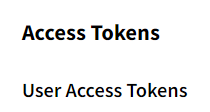

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

您之前已經看過其中的大部分內容：我們設置了一些超參數（例如學習率、要訓練的 epoch 數和權重衰減），然後我們指定 push_to_hub=True 表明我們想要保存模型並在每個時期結束時對其進行評估，並且我們想要將我們的結果上傳到模型中心。請注意，可以使用hub_model_id參數指定要推送到的存儲庫的名稱(特別是，必須使用這個參數來推送到一個組織)。例如，當我們將模型推送到huggingface-course organization, 我們添加了 hub_model_id=huggingface-course/bert-finetuned-ner 到 TrainingArguments 。默認情況下，使用的存儲庫將在您的命名空間中並以您設置的輸出目錄命名，因此在我們的例子中它將是 sgugger/bert-finetuned-ner。

最後，我們只是將所有內容傳遞給 Trainer 並啟動訓練：

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.079600,0.077673,0.909210,0.933692,0.921289,0.980308
2,0.041900,0.054825,0.927818,0.947492,0.937552,0.986048
3,0.025000,0.058029,0.929018,0.949344,0.939071,0.986357


TrainOutput(global_step=5268, training_loss=0.06707108102246678, metrics={'train_runtime': 660.5988, 'train_samples_per_second': 63.765, 'train_steps_per_second': 7.975, 'total_flos': 921792849708600.0, 'train_loss': 0.06707108102246678, 'epoch': 3.0})

請注意，當訓練發生時，每次保存模型時（這裡是每個epooch），它都會在後臺上傳到 Hub。這樣，如有必要，您將能夠在另一臺機器上繼續您的訓練。

訓練完成後，我們使用 push_to_hub() 確保我們上傳模型的最新版本

In [ ]:
#trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/ricerlu/bert-finetuned-ner/commit/6f13c00e4bdd19e78739ca2d69cf56416ce46681', commit_message='Training complete', commit_description='', oid='6f13c00e4bdd19e78739ca2d69cf56416ce46681', pr_url=None, pr_revision=None, pr_num=None)

這 Trainer 還創建了一張包含所有評估結果的模型卡並上傳。在此階段，您可以使用模型中心上的推理小部件來測試您的模型並與您的朋友分享。您已成功在Token分類任務上微調模型 - 恭喜！

如果您想更深入地瞭解訓練循環，我們現在將向您展示如何使用 🤗 Accelerate 做同樣的事情。

## 自定義訓練循環

現在讓我們看一下完整的訓練循環，這樣您可以輕鬆定義所需的部分。它看起來很像我們在第三章, 所做的，對評估進行了一些更改。

### 做好訓練前的準備

首先我們需要為我們的數據集構建 `DataLoader` 。我們將重用我們的 `data_collator` 作為一個 `collate_fn` 並打亂訓練集，但不打亂驗證集：

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

接下來，我們重新實例化我們的模型，以確保我們不會從之前的訓練繼續訓練，而是再次從 BERT 預訓練模型開始：

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


然後我們將需要一個優化器。我們將使用經典 AdamW ，這就像 Adam ，但在應用權重衰減的方式上進行了改進：

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

現在我們已經發送了我們的 train_dataloader 到 accelerator.prepare() ，我們可以使用它的長度來計算訓練步驟的數量。請記住，我們應該始終在準備好dataloader後執行此操作，因為該方法會改變其長度。我們使用經典線性學習率調度：

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

最後，要將我們的模型推送到 Hub，我們需要創建一個 Repository 工作文件夾中的對象。如果您尚未登錄，請先登錄 Hugging Face。我們將從我們想要為模型提供的模型 ID 中確定存儲庫名稱（您可以自由地用自己的選擇替換 repo_name ；它只需要包含您的用戶名，可以使用get_full_repo_name()函數的查看目前的repo_name）：

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'ricerlu/bert-finetuned-ner-accelerate'

In [ ]:
output_dir = "bert-finetuned-ner-accelerate"
#repo = Repository(output_dir, clone_from=repo_name)

## Training loop
### 訓練循環

我們現在準備編寫完整的訓練循環。為了簡化它的評估部分，我們定義了這個 `postprocess()` 接受預測和標籤並將它們轉換為字符串列表的函數，也就是 `metric`對象需要的輸入格式：

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

然後我們可以編寫訓練循環。在定義一個進度條來跟蹤訓練的進行後，循環分為三個部分：

*   訓練本身，這是對train_dataloader的經典迭代，向前傳遞模型，然後反向傳遞和優化參數
*   評估,在獲得我們模型的輸出後:因為兩個進程可能將輸入和標籤填充成不同的形狀,在調用gather()方法前我們需要使用accelerator.pad_across_processes()來讓預測和標籤形狀相同。如果我們不這樣做，評估要麼出錯，要麼永遠不會得到結果。然後，我們將結果發送給metric.add_batch()，並在計算循環結束後調用metric.compute()。
*   保存和上傳，首先保存模型和標記器，然後調用repo.push_to_hub()。注意，我們使用參數blocking=False告訴🤗 hub 庫用在異步進程中推送。這樣，訓練將正常繼續，並且該（長）指令將在後臺執行。

這是訓練循環的完整代碼：

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        #repo.push_to_hub(
        #    commit_message=f"Training in progress epoch {epoch}", blocking=False
        #)

  0%|          | 0/5268 [00:00<?, ?it/s]

epoch 0: {'precision': 0.9431167956916863, 'recall': 0.9229249011857708, 'f1': 0.9329116031296819, 'accuracy': 0.9849149349502561}
epoch 1: {'precision': 0.9481656008078089, 'recall': 0.9246676514032496, 'f1': 0.9362692147901952, 'accuracy': 0.9861953258374051}
epoch 2: {'precision': 0.9481656008078089, 'recall': 0.9246676514032496, 'f1': 0.9362692147901952, 'accuracy': 0.9861953258374051}


果這是您第一次看到用 🤗 Accelerate 保存的模型，讓我們花點時間檢查一下它附帶的三行代碼：

In [ ]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

In [ ]:
!ls -ls bert-finetuned-ner

total 421740
     4 drwxr-xr-x 2 root root      4096 Jan 11 07:19 checkpoint-1756
     4 drwxr-xr-x 2 root root      4096 Jan 11 07:22 checkpoint-3512
     4 drwxr-xr-x 2 root root      4096 Jan 11 07:26 checkpoint-5268
     4 -rw-r--r-- 1 root root      1015 Jan 11 07:34 config.json
420832 -rw-r--r-- 1 root root 430929740 Jan 11 07:34 model.safetensors
     4 -rw-r--r-- 1 root root      1702 Jan 11 07:34 README.md
     4 drwxr-xr-x 3 root root      4096 Jan 11 07:15 runs
     4 -rw-r--r-- 1 root root       125 Jan 11 07:34 special_tokens_map.json
     4 -rw-r--r-- 1 root root      1191 Jan 11 07:34 tokenizer_config.json
   656 -rw-r--r-- 1 root root    669021 Jan 11 07:34 tokenizer.json
     8 -rw-r--r-- 1 root root      4600 Jan 11 07:34 training_args.bin
   212 -rw-r--r-- 1 root root    213450 Jan 11 07:34 vocab.txt


第一行是不言自明的：它告訴所有進程等到都處於那個階段再繼續(阻塞)。這是為了確保在保存之前，我們在每個過程中都有相同的模型。然後獲取unwrapped_model，它是我們定義的基本模型。 accelerator.prepare()方法將模型更改為在分佈式訓練中工作，所以它不再有save_pretraining()方法;accelerator.unwrap_model()方法將撤銷該步驟。最後，我們調用save_pretraining()，但告訴該方法使用accelerator.save()而不是torch.save()。

當完成之後，你應該有一個模型，它產生的結果與Trainer的結果非常相似。你可以在hugs face-course/bert-fine - tuning -ner-accelerate中查看我們使用這個代碼訓練的模型。如果你想測試訓練循環的任何調整，你可以直接通過編輯上面顯示的代碼來實現它們!

###使用微調模型

我們已經向您展示瞭如何使用我們在模型中心微調的模型和推理小部件。在本地使用它 pipeline ，您只需要指定正確的模型標識符：

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "ricerlu/bert-finetuned-ner"
#model_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'entity_group': 'PER',
  'score': 0.9989943,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9762204,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.99794227,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

太棒了！我們的模型與此管道的默認模型一樣有效！

=========================
# 關閉程式，重新啓動， 不然以下呼叫 transformer 會出錯
=========================

In [ ]:
!pip install accelerate>=0.20.1 -U

#*翻譯*

現在讓我們深入研究翻譯。這是另一個sequence-to-sequence 任務，這意味著這是一個可以表述為從一個序列到另一個序列的問題。從這個意義上說，這個問題非常類似文本摘要，並且您可以將我們將在此處學習到的一些內容遷移到其他的序列到序列問題，例如：

*    風格遷移 : 創建一個模型將某種風格遷移到一段文本（例如，正式的風格遷移到休閒的風格或莎士比亞英語到現代英語）
*    生成問題的回答 ：創建一個模型，在給定上下文的情況下生成問題的答案

如果您有足夠大的兩種（或更多）語言的文本語料庫，您可以從頭開始訓練一個新的翻譯模型，就像我們在因果語言建模部分中所做的那樣。然而，微調現有的翻譯模型會更快，無論是從像 mT5 或 mBART 這樣的多語言模型微調到特定的語言對，或者是專門用於從一種語言翻譯成另一種語言的模型。

在本節中，我們將對[KDE4 數據集](https://huggingface.co/datasets/kde4)上的Marian模型進行微調，該模型經過了從英語到法語的翻譯預訓練(因為很多“ Hugging Face”的員工會說這兩種語言)，它是[KDE應用](https://apps.kde.org/)程序本地化文件的數據集。我們將使用的模型已經在從Opus 數據集(實際上包含KDE4數據集)中提取的法語和英語文本的大型語料庫上進行了預先訓練。但是，即使我們使用的預訓練模型在其預訓練期間使用了這部分數據集，我們也會看到，經過微調後，我們可以得到一個更好的版本。

完成後，我們將擁有一個模型，可以進行這樣的翻譯：

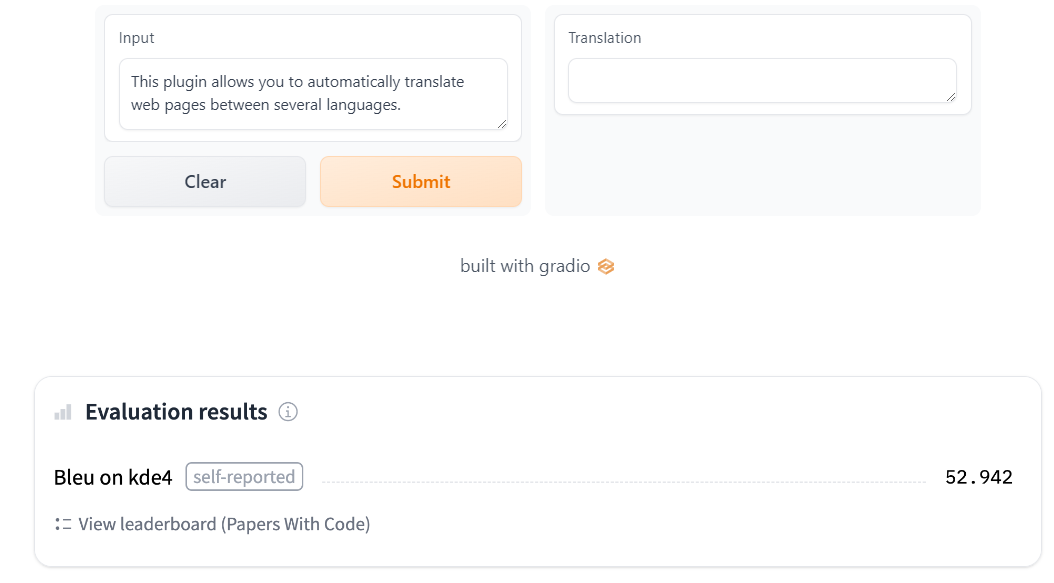

與前面的部分一樣，您可以使用以下代碼找到我們將訓練並上傳到 Hub 的實際模型，並在這裡查看模型輸出的結果

## 準備數據

為了從頭開始微調或訓練翻譯模型，我們需要一個適合該任務的數據集。如前所述，我們將使用KDE4 數據集在本節中，但您可以很容易地調整代碼以使用您自己的數據，只要您有要互譯的兩種語言的句子對。如果您需要複習如何將自定義數據加載到 Dataset 可以複習一下第五章.

### KDE4 數據集

像往常一樣，我們使用 load_dataset() 函數：

In [2]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


如果您想使用不同的語言對，您可以使用它們的代碼來指定它們。該數據集共有 92 種語言可用；您可以通過數據集卡片展開其上的語言標籤來查看它們.

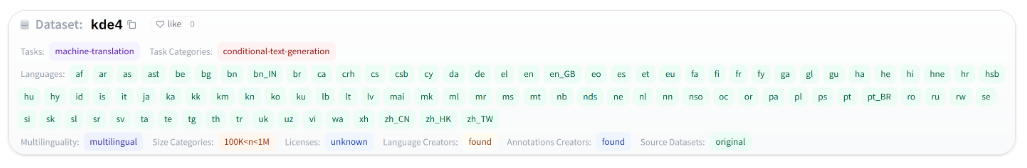

我們來看看數據集：

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

我們有 210,173 對句子，但在一次訓練過程中，我們需要創建自己的驗證集。正如我們在第五章學的的那樣, Dataset 有一個 train_test_split() 方法,可以幫我們拆分數據集。我們將設定固定的隨機數種子：

In [4]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

我們可以將 test 的鍵重命名為 validation 像這樣：

In [5]:
split_datasets["validation"] = split_datasets.pop("test")

現在讓我們看一下數據集的一個元素：

In [6]:
split_datasets["train"][1]["translation"]

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

我們得到一個字典，其中包含我們請求的兩種語言的兩個句子。這個充滿技術計算機科學術語的數據集的一個特殊之處在於它們都完全用法語翻譯。然而，法國工程師通常很懶惰，在交談時，大多數計算機科學專用詞彙都用英語表述。例如，“threads”這個詞很可能出現在法語句子中，尤其是在技術對話中；但在這個數據集中，它被翻譯成更正確的“fils de Discussion”。我們使用的預訓練模型已經在一個更大的法語和英語句子語料庫上進行了預訓練，採用了更簡單的選擇，即保留單詞的原樣:

In [1]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Par défaut pour les threads élargis'}]

這種情況的另一個例子是“plugin”這個詞，它不是正式的法語詞，但大多數母語人士都能理解，也不會費心去翻譯。 在 KDE4 數據集中，這個詞在法語中被翻譯成更正式的“module d’extension”：

In [7]:
split_datasets["train"][172]["translation"]

{'en': 'Unable to import %1 using the OFX importer plugin. This file is not the correct format.',
 'fr': "Impossible d'importer %1 en utilisant le module d'extension d'importation OFX. Ce fichier n'a pas un format correct."}

然而，我們的預訓練模型堅持使用簡練而熟悉的英文單詞：

In [8]:
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)

[{'translation_text': "Impossible d'importer %1 en utilisant le plugin d'importateur OFX. Ce fichier n'est pas le bon format."}]

看看我們的微調模型是否能識別數據集的這些特殊性。（劇透警告：它會）。

### 處理數據

您現在應該知道我們的下一步該做些什麼了：所有文本都需要轉換為token ID，以便模型能夠理解它們。對於這個任務，我們需要同時標記輸入和目標。我們的首要任務是創建我們的 tokenizer 對象。如前所述，我們將使用 Marian 英語到法語的預訓練模型。如果您使用另一對語言嘗試此代碼，請確保調整模型Checkpoint。Helsinki-NLP組織提供了多種語言的一千多種模型。

In [9]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="tf")

您可以將 model_checkpoint 更換為Hub上你喜歡的任何其他型號，或本地保存的預訓練模型和標記器。

我們的數據準備非常簡單。 只需要記住一件事：您照常處理輸入，但對於這次的輸出目標，您需要將標記器包裝在上下文管理器“as_target_tokenizer()”中。

Python 中的上下文管理器引入了 with 語句，當您有兩個相關的操作要成對執行時很有用。最常見的例子是當您寫入或讀取文件時，下面是一個例子：

In [11]:
#with open(file_path) as f:
#    content = f.read()

這裡成對執行的兩個相關操作是打開和關閉文件的操作。打開的文件f對應的對象只在with下的縮進塊內有效；在該塊之前打開，在該塊的末尾關閉。

在本例中，上下文管理器 as_target_tokenizer() 將在執行縮進塊之前將標記器設置為輸出語言（此處為法語），然後將其設置回輸入語言（此處為英語）。

因此，預處理一個樣本如下所示：

In [12]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence)
with tokenizer.as_target_tokenizer():
    targets = tokenizer(fr_sentence)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


如果我們忘記在上下文管理器中標記目標，它們將被輸入標記器標記，在Marian模型的情況下，會導致輸出的異常：

In [13]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['▁Par', '▁dé', 'f', 'aut', ',', '▁dé', 've', 'lop', 'per', '▁les', '▁fil', 's', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


正如我們所看到的，使用英語標記器來預處理法語句子會產生更多的標記，因為標記器不知道任何法語單詞(除了那些也出現在英語語言中的單詞，比如“discussion”)。

inputs 和 targets 都是帶有我們常用鍵（輸入 ID、注意掩碼等）的字典，所以最後一步是在輸入中設置一個 "labels" 鍵。 我們在數據集的預處理函數中執行此操作：

In [14]:
max_input_length = 128
max_target_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

請注意，我們為輸入和輸出設置了相同的最大長度。由於我們處理的文本看起來很短，我們使用 128。

我們現在可以對數據集的所有數據一次性應用該預處理：

In [15]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

Map:   0%|          | 0/189155 [00:00<?, ? examples/s]

Map:   0%|          | 0/21018 [00:00<?, ? examples/s]

現在數據已經過預處理，我們準備好微調我們的預訓練模型！

### 使用 Trainer API 微調模型

使用 Trainer 的實際代碼將與以前相同，只是稍作改動：我們在這裡使用 Seq2SeqTrainer， 它是 Trainer 的子類，它可以正確處理這種序列到序列的評估，並使用 generate() 方法來預測輸入的輸出。 當我們討論評估指標時，我們將更詳細地探討這一點。

首先，我們需要一個實際的模型來進行微調。 我們將使用通常的 AutoModel API：

In [16]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

請注意，這次我們使用的是在翻譯任務上訓練過的模型，並且實際上已經可以使用，因此沒有關於丟失權重或新初始化權重的警告。

### 數據整理

我們需要一個數據整理器來處理動態批處理的填充。在本例中，我們不能像第3章那樣使用帶填充的DataCollatorWithPadding，因為它只填充輸入（輸入ID、注意掩碼和令牌類型ID）。我們的標籤也應該填充到標籤中遇到的最大長度。而且，如前所述，用於填充標籤的填充值應為-100，而不是標記器的填充標記，以確保在損失計算中忽略這些填充值。

這一切都可以由 DataCollatorForSeq2Seq 完成。 與 DataCollatorWithPadding 一樣，它採用用於預處理輸入的tokenizer，但它也採用model。 這是因為數據整理器還將負責準備解碼器輸入 ID，它們是標籤偏移之後形成的，開頭帶有特殊標記。 由於不同架構的這種轉變略有不同，因此“DataCollatorForSeq2Seq”需要知道“模型”對象：

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

為了在幾個樣本上進行測試，我們只需在我們標記化訓練集中的部分數據上調用它：

In [18]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

我們可以檢查我們的標籤是否已使用 -100 填充到批次的最大長度：

In [19]:
batch["labels"]

tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]])

我們還可以查看解碼器輸入 ID，看看它們是標籤的偏移形成的版本：

In [20]:
batch["decoder_input_ids"]

tensor([[59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
         59513, 59513, 59513, 59513, 59513, 59513],
        [59513,  1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,
           817,   550,  7032,  5821,  7907, 12649]])

以下是我們數據集中第一個和第二個元素的標籤：

In [21]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

[577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]
[1211, 3, 49, 9409, 1211, 3, 29140, 817, 3124, 817, 550, 7032, 5821, 7907, 12649, 0]


我們將把這個 data_collator 傳遞給 Seq2SeqTrainer。 接下來，讓我們看一下評估指標。

### 評估指標

eq2SeqTrainer 添加到其超類 Trainer 的功能是在評估或預測期間使用 generate() 方法的能力。 在訓練期間，模型將使用帶有注意掩碼的“decoder_input_ids”，以確保它不使用預測的標記之後的標記，以加快訓練速度。 在推理過程中，我們將無法使用預測的標記之後的標記，因為我們沒有標籤，因此使用相同的設置使用帶有注意掩碼的“decoder_input_ids”，評估我們的模型是個好主意。

正如我們在第一章看到的，解碼器通過一個一個地預測標記來執行推理——這是🤗 Transformers 在幕後通過 generate() 方法實現的。如果我們設置 predict_with_generate=True，Seq2 Seq Trainer 將允許我們使用該方法進行評估。

用於翻譯的傳統指標是BLEU 分數, 由Kishore Papineni等人在2002年的一篇文章中引入。BLEU 分數評估翻譯與其標籤的接近程度。它不衡量模型生成輸出的可懂度或語法正確性，而是使用統計規則來確保生成輸出中的所有單詞也出現在目標中。此外，如果相同單詞在目標中沒有重複，則有規則懲罰相同單詞的重複（以避免模型輸出類似 the the the the the的句子 ) 並輸出比目標中短的句子（以避免模型輸出像 the 這樣的句子）。

BLEU 的一個缺點是它需要文本已經被分詞，這使得比較使用不同標記器的模型之間的分數變得困難。因此，當今用於基準翻譯模型的最常用指標是SacreBLEU，它通過標準化標記化步驟解決了這個缺點（和其他的一些缺點）。要使用此指標，我們首先需要安裝 SacreBLEU 庫：

In [22]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.4 MB/s eta 0:00:00


然後我們可以就像我們在第三章那樣通過 load_metric() 加載它 ：

In [23]:
from datasets import load_metric

metric = load_metric("sacrebleu")

<ipython-input-23-a15d7a2cd8c7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


該指標將文本作為輸入和目標結果。它旨在接受多個可接受的目標，因為同一個句子通常有多個可接受的翻譯——我們使用的數據集只提供一個，但在 NLP 中找到將多個句子作為標籤的數據集不是一個難題。因此，預測結果應該是一個句子列表，而參考應該是一個句子列表的列表。

讓我們嘗試一個例子：

In [24]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

這得到了 46.75 的 BLEU 分數，這是相當不錯的——作為參考，原始 Transformer 模型在“Attention Is All You Need” 論文類似的英語和法語翻譯任務中獲得了 41.8 的 BLEU 分數！ （有關各個指標的更多信息，例如 counts 和 bp ，見SacreBLEU 倉庫.) 另一方面，如果我們嘗試使用翻譯模型中經常出現的兩種糟糕的預測類型（大量重複或太短），我們將得到相當糟糕的 BLEU 分數：

In [25]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [26]:
predictions = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

分數可以從 0 到 100，越高越好。

為了從模型輸出到度量可以使用的文本，我們將使用 tokenizer.batch_decode() 方法。 我們只需要清理標籤中的所有 -100（標記器將自動對填充標記執行相同操作）：

In [27]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

現在這已經完成了，我們已經準備好微調我們的模型了！

### 微調模型
第一步是登錄 Hugging Face，這樣您就可以將結果上傳到模型中心。有一個方便的功能可以幫助您在notebook中完成此操作：

In [28]:
from huggingface_hub import notebook_login

notebook_login()

這將顯示一個小部件，您可以在其中輸入您的 Hugging Face 登錄憑據。

如果您不是在notebook上運行代碼，只需在終端中輸入以下行：

In [ ]:
#huggingface-cli login

一旦完成，我們就可以定義我們的 Seq2SeqTrainingArguments。 與 Trainer 一樣，我們使用 TrainingArguments 的子類，其中包含更多可以設置的字段：

In [29]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

除了通常的超參數（如學習率、訓練輪數、批次大小和一些權重衰減）之外，與我們在前幾節中看到的相比，這裡有一些變化：

我們沒有設置任何定期評估，因為評估需要耗費一定的時間；我們只會在訓練開始之前和結束之後評估我們的模型一次。
我們設置fp16=True，這可以加快支持fp16的 GPU 上的訓練速度。
和上面我們討論的那樣，我們設置predict_with_generate=True
我們用push_to_hub=True在每個 epoch 結束時將模型上傳到 Hub。
請注意，您可以使用 hub_model_id 參數指定要推送到的存儲庫的名稱（當您想把模型推送到指定的組織的時候，您也必須使用此參數）。 例如，當我們將模型推送到 huggingface-course 組織 時，我們添加了 hub_model_id="huggingface-course/marian-finetuned-kde4-en- to-fr" 到 Seq2SeqTrainingArguments。 默認情況下，使用的存儲庫將在您的命名空間中，並以您設置的輸出目錄命名，因此這裡將是 "sgugger/marian-finetuned-kde4-en-to-fr"。

最後，我們需要將所有內容傳遞給 Seq2SeqTrainer ：


In [31]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

在訓練之前，我們將首先查看我們的模型獲得的分數，以仔細檢查我們的微調沒有讓事情變得更糟。此命令需要一些時間，因此您可以在執行時喝杯咖啡：

大約跑半小時

In [32]:
trainer.evaluate(max_length=max_target_length)

{'eval_loss': 1.696446418762207,
 'eval_bleu': 39.166011386870395,
 'eval_runtime': 1606.3125,
 'eval_samples_per_second': 13.085,
 'eval_steps_per_second': 0.205}

BLEU的分數還不錯，這反映了我們的模型已經擅長將英語句子翻譯成法語句子。

接下來是訓練，這也需要一些時間：
大約一小時

In [ ]:
trainer.train()

Step,Training Loss


請注意，當訓練發生時，每次保存模型時（這裡是每個時期），它都會在後臺上傳到 Hub。這樣，如有必要，您將能夠在另一臺機器上繼續您的訓練。

訓練完成後，我們再次評估我們的模型——希望我們會看到 BLEU 分數有所改善！

In [ ]:
trainer.evaluate(max_length=max_target_length)

這是近 14 點的改進，這很棒。

最後，我們使用 push_to_hub() 方法來確保我們上傳模型的最新版本。這 Trainer 還創建了一張包含所有評估結果的模型卡並上傳。此模型卡包含可幫助模型中心為推理演示選擇小部件的元數據。通常不需要做額外的更改，因為它可以從模型類中推斷出正確的小部件，但在這種情況下，相同的模型類可以用於所有類型的序列到序列問題，所以我們指定它是一個翻譯模型：

In [ ]:
trainer.push_to_hub(tags="translation", commit_message="Training complete")

如果您想檢查命令執行的結果，此命令將返回它剛剛執行的提交的 URL，可以打開url進行檢查：

'https://huggingface.co/sgugger/marian-finetuned-kde4-en-to-fr/commit/3601d621e3baae2bc63d3311452535f8f58f6ef3'

在此階段，您可以使用模型中心上的推理小部件來測試您的模型並與您的朋友分享。您已成功微調翻譯任務的模型 - 恭喜！

如果您想更深入地瞭解訓練循環，我們現在將向您展示如何使用 🤗 Accelerate 做同樣的事情。

### 自定義訓練循環

現在讓我們看一下完整的訓練循環，以便您可以輕鬆自定義所需的部分。它看起來很像我們在本章第二節和第三章第四小節所做的。

#### 準備訓練所需的一切

您已經多次看到所有這些，因此這一塊會簡略進行。首先我們將構建我們的數據集的DataLoader ，在將數據集設置為 torch 格式，我們就得到了 PyTorch 張量：

In [ ]:
from torch.utils.data import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

接下來我們重新實例化我們的模型，以確保我們不會繼續上一節的微調，而是再次從預訓練模型開始重新訓練：

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

然後我們需要一個優化器：

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

一旦我們擁有所有這些對象，我們就可以將它們發送到 accelerator.prepare() 方法。 請記住，如果您想在 Colab 筆記本訓練中使用TPU，則需要將所有這些代碼移動到訓練函數中，並且不應執行任何實例化“加速器”的對象。

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

現在我們已經發送了我們的 train_dataloader 到 accelerator.prepare() ，我們可以使用它的長度來計算訓練步驟的數量。請記住，我們應該始終在準備好數據加載器後執行此操作，因為該方法會更改 DataLoader .我們使用從學習率衰減到 0 的經典線性學習率調度：

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

最後，要將我們的模型推送到 Hub，我們需要創建一個 Repository 工作文件夾中的對象。如果您尚未登錄，請先登錄 Hugging Face。我們將從我們想要為模型提供的模型 ID 中確定存儲庫名稱（您可以自由地用自己的選擇替換 repo_name ；它需要包含您的用戶名，可以使用get_full_repo_name()函數的查看目前的repo_name）：

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-kde4-en-to-fr-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

然後我們可以在本地文件夾中克隆該存儲庫。如果它已經存在，這個本地文件夾應該是我們正在使用的存儲庫的克隆：

In [ ]:
output_dir = "marian-finetuned-kde4-en-to-fr-accelerate"
#repo = Repository(output_dir, clone_from=repo_name)

我們現在可以通過調用 repo.push_to_hub() 方法上傳我們保存的任何內容 output_dir 。這將幫助我們在每個 epoch 結束時上傳過程中的模型。

### 訓練循環
我們現在準備編寫完整的訓練循環。為了簡化它的評估部分，我們定義了這個 postprocess() 函數接收預測結果和正確標籤並將它們轉換為我們 metric 對象所需要的字符串列表：

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels

訓練循環看起來和本章第二節與第三章很像，在評估部分有一些不同 - 所以讓我們專注於這一點！

首先要注意的是我們使用 generate() 方法來計算預測，但這是我們基礎模型上的一個方法，而不是包裝模型🤗 Accelerate 在 prepare() 方法中創建。 這就是為什麼我們先解包模型，然後調用這個方法。

第二件事是，就像token 分類，兩個進程可能將輸入和標籤填充為不同的形狀，因此我們在調用 gather() 方法之前使用 accelerator.pad_across_processes() 使預測和標籤具有相同的形狀。如果我們不這樣做，評估要麼出錯，要麼永遠在阻塞。

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    results = metric.compute()
    print(f"epoch {epoch}, BLEU score: {results['score']:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        #repo.push_to_hub(
        #    commit_message=f"Training in progress epoch {epoch}", blocking=False
        #)

完成此操作後，您應該有一個模型，其結果與使用 Seq2SeqTrainer 訓練的模型非常相似。 您可以在 [huggingface-course/marian-finetuned-kde4-en-to-fr-accelerate](https://huggingface.co/huggingface-course/marian-finetuned-kde4-en-to-fr-accelerate）查看訓練完的結果。 如果您想測試對訓練循環的任何調整，您可以通過編輯上面顯示的代碼直接實現它們！

使用微調後的模型
我們已經向您展示瞭如何將我們在模型中心微調的模型與推理小部件一起使用。 要在“管道”中本地使用它，我們只需要指定正確的模型標識符：

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/marian-finetuned-kde4-en-to-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

正如預期的那樣，我們的預訓練模型將其知識適應了我們對其進行微調的語料庫，而不是單獨留下英文單詞“threads”，而是將其翻譯成法語官方版本。 “”的翻譯也是一樣的：

風格適應的另一個很好的例子！